<a href="https://colab.research.google.com/github/Metallicode/Math/blob/main/Using_Clustering_For_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(sub_p_res)

Tesla T4, 15360 MiB, 15101 MiB



#Using Clustering For Preprocessing

In [3]:
import numpy as np

##load_digits

In [4]:
from sklearn.datasets import load_digits

In [5]:
X_digits, y_digits = load_digits(return_X_y=True)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

##LogisticRegression Model

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
logistic_reg_model = LogisticRegression(max_iter=5000)

In [10]:
logistic_reg_model.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [11]:
logistic_reg_model.score(X_test,y_test)

0.9577777777777777

##Using K-Means for Preprocessing

In [12]:
from sklearn.cluster import KMeans

In [13]:
from sklearn.pipeline import Pipeline

In [14]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50)),
    ("log_reg", LogisticRegression(max_iter=5000))])

pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                ('log_reg', LogisticRegression(max_iter=5000))])

In [15]:
pipeline.score(X_test,y_test)

0.9555555555555556

##Using GridSearchCV ro find Optimal K

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
param_grid = dict(kmeans__n_clusters=range(2,100))

In [18]:
grid_classifier = GridSearchCV(pipeline, param_grid, cv=3, verbose=0)

In [ ]:
grid_classifier.fit(X_train, y_train)

In [20]:
grid_classifier.best_params_

{'kmeans__n_clusters': 85}

In [21]:
grid_classifier.score(X_test,y_test)

0.9688888888888889

##Using Clustring for Semi-Supervised Learning

In [22]:
n_labeled = 50
log_reg =  LogisticRegression(max_iter=1000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled]) # <------ train model on small dataset

LogisticRegression(max_iter=1000)

In [23]:
log_reg.score(X_test,y_test)  # <----- Bad Score

0.8422222222222222

 applies k-means clustering on the training data. The intention here is to group similar images together into k clusters, where k is 50 in this instance. The method fit_transform returns a matrix (X_digits_dist) that indicates the distance of each image to each of the 50 cluster centroids.

Thus, if X_train has a shape (m, n), where m is the number of images and n is the number of features (or pixels) per image, then X_digits_dist will have a shape (m, 50). Each row of this matrix corresponds to an image, and each column corresponds to a cluster centroid. The value at position (i, j) gives the distance of the i-th image to the j-th cluster centroid.

Here, the goal is to identify which image is closest to each cluster centroid, as it will be seen as a representative image for that cluster. The function np.argmin(X_digits_dist, axis=0) returns the index of the image with the smallest distance to each centroid. The result is an array of 50 indices, one for each cluster.

Using these indices, the representative images can be extracted from X_train.

In [24]:
k = n_labeled
kmeans = KMeans(n_clusters=k)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0) #For each of the 50 columns, tell me the row index where the smallest value of that column is located
X_representative_digits = X_train[representative_digit_idx]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


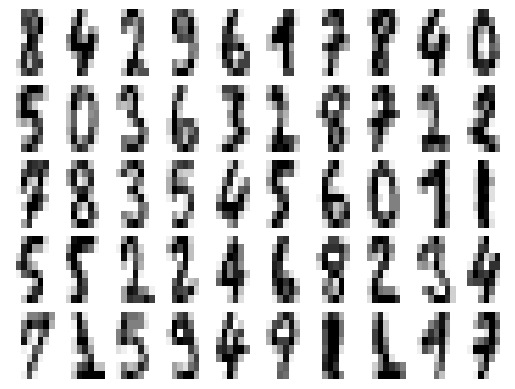

In [30]:
import numpy as np
import matplotlib.pyplot as plt

image_size = 8
margin = 1
grid_rows = 5
grid_cols = 10

# Adjust the grid size to account for the margins.
grid_image = np.ones(((image_size + margin) * grid_rows - margin,
                      (image_size + margin) * grid_cols - margin)) * 255

for idx, image in enumerate(X_representative_digits):
    row = idx // grid_cols
    col = idx % grid_cols
    start_row = row * (image_size + margin)
    start_col = col * (image_size + margin)
    grid_image[start_row:start_row+image_size, start_col:start_col+image_size] = 255 - image.reshape(image_size, image_size)

plt.imshow(grid_image, cmap='gray', aspect='auto')
plt.axis('off')
plt.show()


##Manual Classification

In [35]:
lables = np.array([8,4,2,9,6,4,7,8,4,0,
          5,0,3,6,3,2,8,7,2,2,
          7,8,3,5,4,5,6,0,1,1,
          5,5,2,2,4,6,8,2,3,4,
          7,1,5,9,4,9,1,1,4,7,])

In [36]:
log_reg_labeld =  LogisticRegression(max_iter=1000)
log_reg_labeld.fit(X_representative_digits, lables)

LogisticRegression(max_iter=1000)

In [37]:
log_reg_labeld.score(X_test,y_test)

0.8733333333333333

##Label Propagation

In [43]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
  y_train_propagated[kmeans.labels_==i] = lables[i]

In [44]:
percentile_closest = 20

In [45]:
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

for i in range(k):
  in_cluster = (kmeans.labels_ == i)
  cluster_dist = X_cluster_dist[in_cluster]
  cutoff_distance = np.percentile(cluster_dist, percentile_closest)
  above_cutoff = (X_cluster_dist > cutoff_distance)
  X_cluster_dist[in_cluster & above_cutoff] = -1

**Identifying instances in each cluster that are further away from their cluster's centroid than a specified percentile of distances.**

1. **Purpose of the Loop**:
    The loop iterates over each cluster, from cluster `0` to cluster `k-1`.

2. **Getting All Instances of the Current Cluster**:
    ```python
    in_cluster = (kmeans.labels_ == i)
    ```
    This creates a Boolean array where each entry is `True` if the instance belongs to the current cluster (`i`) and `False` otherwise.

3. **Get Distances of Instances in the Current Cluster to its Centroid**:
    ```python
    cluster_dist = X_cluster_dist[in_cluster]
    ```
    This extracts the distances of all the instances that belong to the current cluster from the array of distances (`X_cluster_dist`). Now, `cluster_dist` contains distances of only those instances which are part of the current cluster (`i`).

4. **Determine the Cutoff Distance**:
    ```python
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    ```
    Based on the distances in `cluster_dist`, the `cutoff_distance` is calculated as the distance at the `percentile_closest` percentile.

5. **Which Distances Exceed the Cutoff?**:
    ```python
    above_cutoff = (X_cluster_dist > cutoff_distance)
    ```
    This creates another Boolean array. For every instance in the dataset (not just the current cluster), it checks if its distance to its cluster's centroid exceeds the `cutoff_distance`.

6. **Set Distances Above the Cutoff to -1 for the Current Cluster**:
    ```python
    X_cluster_dist[in_cluster & above_cutoff] = -1
    ```
    
    Here, the code is combining two conditions:
    - The instance belongs to the current cluster (`in_cluster`).
    - The instance's distance to its centroid is above the `cutoff_distance` (`above_cutoff`).
    
    The instances that meet both conditions have their distances set to `-1` in the `X_cluster_dist` array.



```
myList = np.array([1,2,4,3,5,4,3,2])
boolz_1 = np.array([False,True,False,False,True,False,False,True])
boolz_2 = np.array([False,False,False,False,True,False,False,False])
myList[boolz_1 & boolz_2]

```

In [46]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train[partially_propagated]

##Train the Model

In [47]:
log_reg_partially =  LogisticRegression(max_iter=1000)
log_reg_partially.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg_partially.score(X_test,y_test)

0.9333333333333333